# Cameroon/Millet example

The aim of this notebook is to show how to use the SARRA-Py package to prepare data and perform atteinable yield simulations for millet in Cameroon.

# Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd

## 1. Defining simulation dates

We start by defining `date_start`, the date at which simulation is started, and the duration of the simulation in days.

The date at which simulation is started will define the first date at which data will be loaded, and from which the water balance will be computed on a daily basis. It is better to start the simulation around one month before expected sowing date in order to permit water balance computations to stabilize before the effective sowing date. It is especially important as the date of emergence phase is triggered by a certain amount of water in the soil.

The duration of the simulation, in days, define the number of daily cycles after which the simulation will be stopped, and thus the size of the time dimension in the computation arrays. Only the days between `date_start` and `date_start + duration` will be used for computations.

In [37]:
date_start = datetime.date(2020,4,1)
duration = 365-(date_start-datetime.date(date_start.year,1,1)).days

## 2. Preparing the base dataset

The base dataset aims to contain weather and soil information, which will remain the same for a given location and time period. By preparing it independently, we can then call it multiple times without the need to prepare weather and soil data again.

We provide example rainfall and climate data for Niger, 2017 ; uncomment the following code to extract it to the `./data/exemple_data/` path.

In [38]:
# import zipfile

# path_to_zip_file = "../data/exemple_data/exemple_data_niger_2017.zip"
# directory_to_extract_to = "../data/exemple_data/"

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

First, we define the path towards rainfall and climate datasets. As indicated by their names, the daily rainfall dataset is provided by TAMSAT, and the daily climate dataset is provided by ERA5. These datasets consist of series of geotiff files, one per day. The spatial extent of the rainfall dataset defines the spatial extent of the simulation.

In [39]:
# we provide the path to the example data
# rainfall_data_path = "../data/exemple_data/TAMSAT_v3.1_niger_rfe_filled/"
# climate_data_path = "../data/exemple_data/AgERA5_niger/"

# alternatively, tap into the climate data that we already have retrieved for Niger, 1983-2022
rainfall_data_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/CHIRPS_v2.0_Africa_north_cameroon"
climate_data_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/AgERA5_north_cameroon/"

Then, we determine the dimensions of the gridded rainfall dataset, as one logic in SARRA-Py is to use the same resolution as the rainfall dataset.

In [40]:
grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)
print("The grid is {} pixels wide by {} pixels high.".format(grid_width, grid_height))

The grid is 153 pixels wide by 111 pixels high.


Next, we initialize our base dataset, and load the rainfall and climate data. We also load the soil parameters, which are provided in the package for the whole continent. Finally, we compute the day length, which is independent of parameters (and thus needs to be in the base dataset), and is needed in computations.

In [41]:
# initialize empty xarray dataset
base_data = xr.Dataset()

# load rainfall and weather data
base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

# load soil parameters
base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

# compute day length raster
base_data = calc_day_length_raster_fast(base_data, date_start, duration)

  0%|          | 0/5 [00:00<?, ?it/s]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


 40%|████      | 2/5 [00:15<00:22,  7.63s/it]

2m_temperature_24_hour_minimum
ET0Hargeaves


 80%|████████  | 4/5 [00:30<00:07,  7.74s/it]

solar_radiation_flux_daily


100%|██████████| 5/5 [00:45<00:00,  9.19s/it]


As we may see below, the base dataset is a `xarray.Dataset` object, which contains the rainfall and climate data, as well as the soil parameters. It also contains the day length, which is computed from the latitude of the location.

In [42]:
base_data

<xarray.Dataset>
Dimensions:           (x: 111, y: 153, time: 274)
Coordinates:
  * x                 (x) float64 10.68 10.73 10.78 10.83 ... 16.08 16.13 16.18
  * y                 (y) float64 13.32 13.27 13.22 13.17 ... 5.825 5.775 5.725
    spatial_ref       int64 0
Dimensions without coordinates: time
Data variables: (12/13)
    rain              (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tpMoy             (time, y, x) float32 nan nan nan nan ... 26.06 26.06 25.87
    ET0               (time, y, x) float32 nan nan nan nan ... 3.446 3.446 3.293
    rg                (time, y, x) float32 nan nan nan nan ... 22.38 22.38 22.37
    profRu            (y, x) float32 1.15e+03 1.15e+03 400.0 ... 1.5e+03 1.5e+03
    epaisseurSurf     (y, x) float32 200.0 200.0 200.0 ... 200.0 200.0 200.0
    ...                ...
    soil_type         (y, x) float32 9.0 9.0 9.0 9.0 9.0 ... 6.0 6.0 6.0 6.0 6.0
    runoff_threshold  (y, x) float32 18.0 18.0 18.0 18.0 ... 15.0 15.0 15.0 15.0
    runoff_rate       (y, x) float32 0.32 0.32 0.32 0.32 ... 0.35 0.35 0.35 0.35
    RZPAWC            (y, x) float32 74.0 76.0 24.0 0.0 ... 110.0 149.0 145.0
    ru                (y, x) float32 64.35 66.09 60.0 0.0 ... 95.65 99.33 96.67
    dureeDuJour       (time, y, x) float64 12.26 12.26 12.26 ... 11.79 11.79

## 3. Preparing a simulation dataset

In this section, we will be loading simulation-specific parameters, and preparing the data accordingly. First, we will load the variety parameters file (`file_paramVariete`), the agricultural itinerary parameters file (`file_paramITK`) as well as the soil parameters file (`file_paramTypeSol`) by calling the `load_YAML_parameters` function. All these files can be found commented in the `./data/params/` folder. We incite you to make copies of the provided examples and play around with parameters by calling your copies.

In [43]:
# parameter file names
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_cameroon_2020.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# load variety, cropping system and soil parameters
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

Once the parameters are loaded, we build up the simulation dataset by copying the base dataset, and adding the simulation-specific parameters.

In [44]:
# creato,g simulation xarray dataset by copying the base data
data = base_data.copy()

# initializing all the necessary variables
data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
data = initialize_default_irrigation(data)
data = calculate_once_daily_thermal_time(data, paramVariete)

The resulting dataset is a `xarray.Dataset` object, which contains all initialized variables for computations.

In [45]:
data

<xarray.Dataset>
Dimensions:                      (x: 111, y: 153, time: 274)
Coordinates:
  * x                            (x) float64 10.68 10.73 10.78 ... 16.13 16.18
  * y                            (y) float64 13.32 13.27 13.22 ... 5.775 5.725
    spatial_ref                  int64 0
Dimensions without coordinates: time
Data variables: (12/111)
    rain                         (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    tpMoy                        (time, y, x) float32 nan nan ... 26.06 25.87
    ET0                          (time, y, x) float32 nan nan ... 3.446 3.293
    rg                           (time, y, x) float32 nan nan ... 22.38 22.37
    profRu                       (y, x) float32 1.15e+03 1.15e+03 ... 1.5e+03
    epaisseurSurf                (y, x) float32 200.0 200.0 ... 200.0 200.0
    ...                           ...
    sumPP                        (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    TigeUp                       (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    UBTCulture                   (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    lai                          (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    Ncrit                        (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    irrigation                   (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0

## 4. Running the model

Once the dataset is built, the model can be run by simply calling the `run_model` function. This function will perform the computations, and return an updated `xarray.Dataset` object containing the results.

In [46]:
data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)

100%|██████████| 274/274 [03:25<00:00,  1.33it/s]


## 5. Mapping results

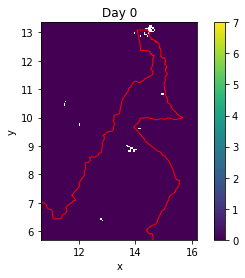

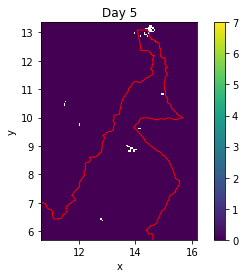

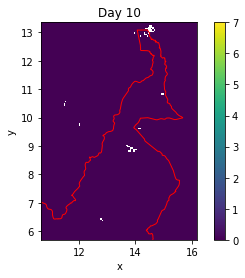

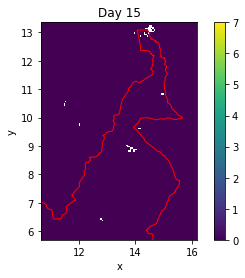

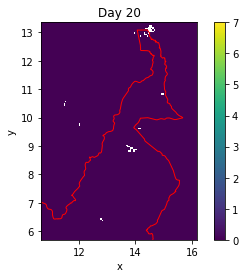

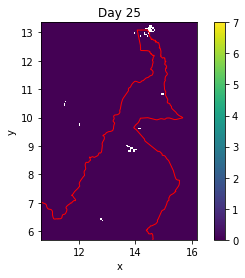

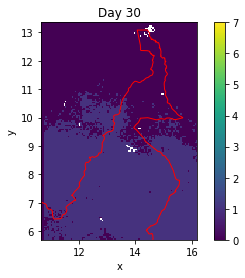

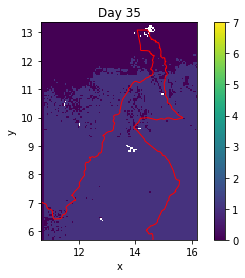

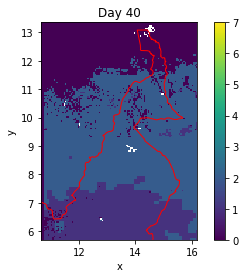

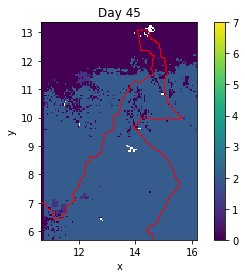

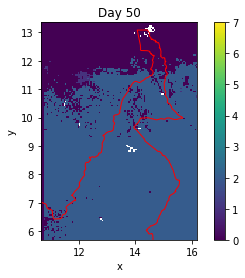

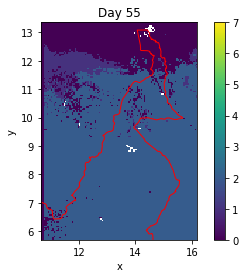

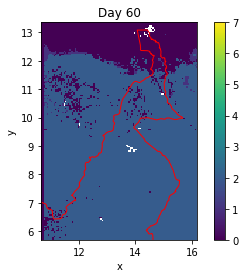

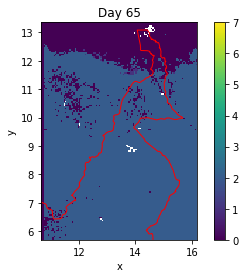

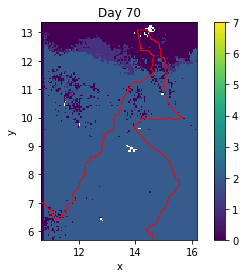

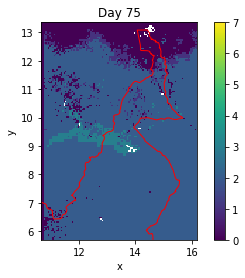

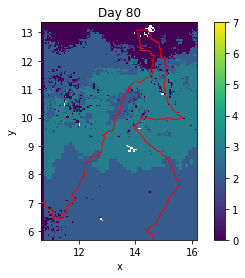

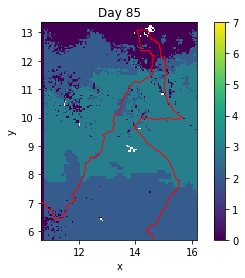

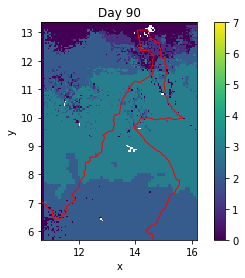

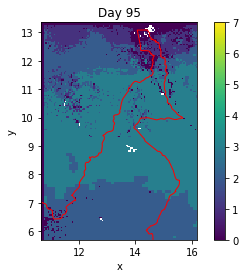

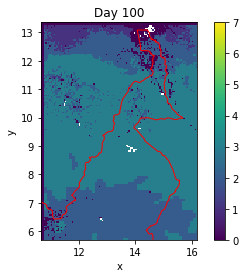

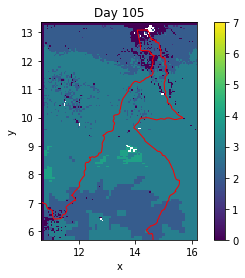

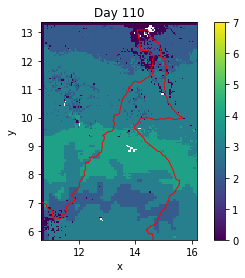

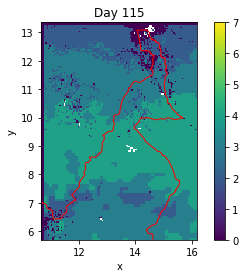

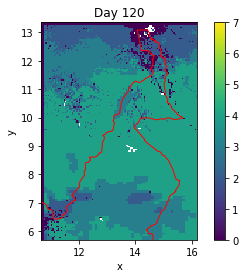

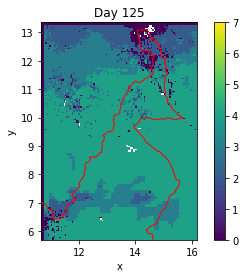

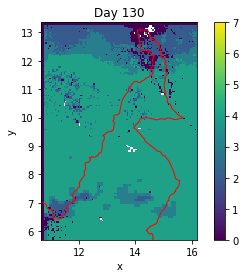

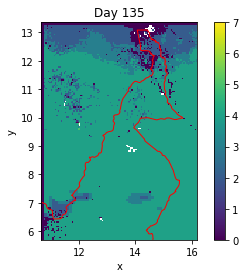

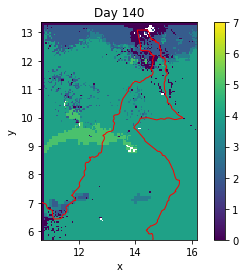

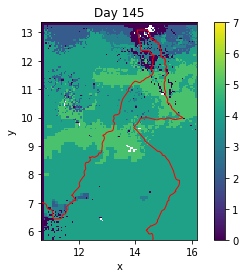

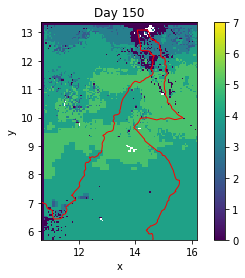

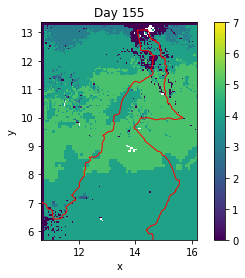

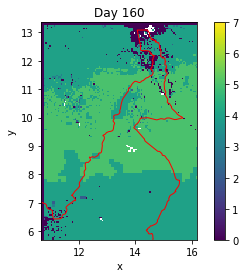

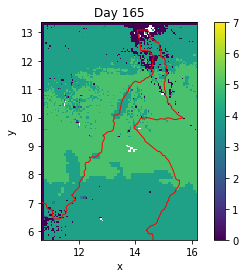

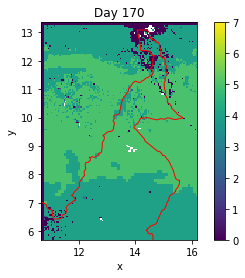

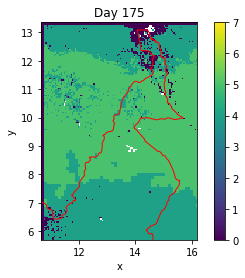

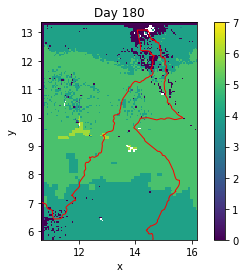

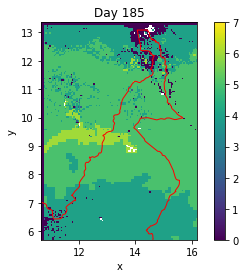

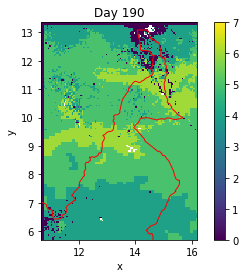

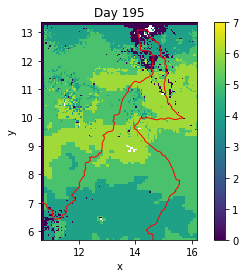

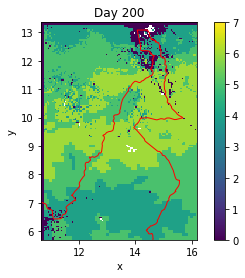

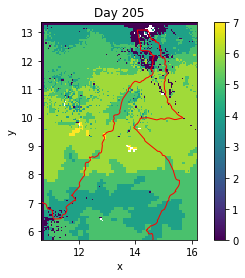

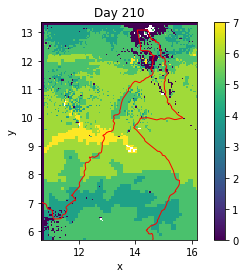

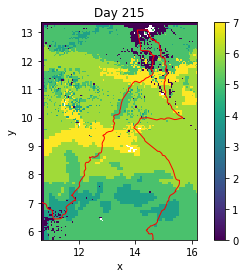

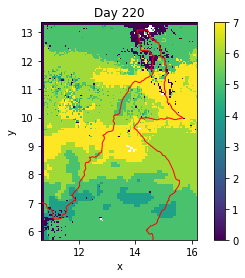

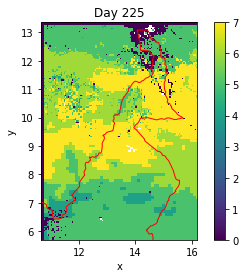

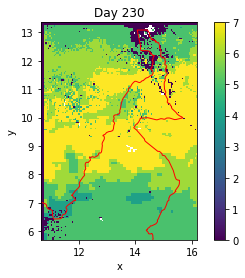

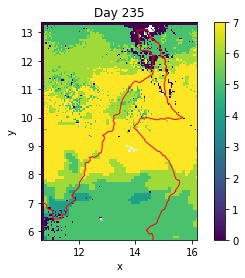

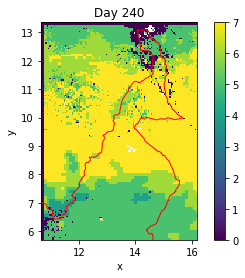

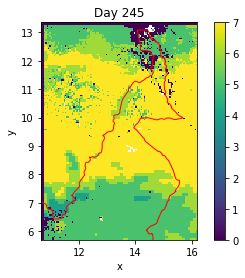

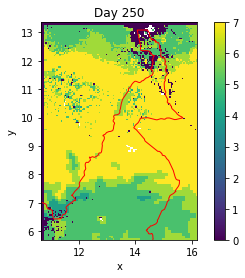

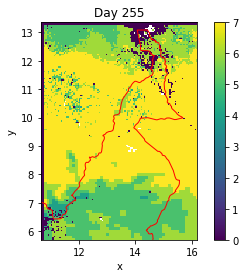

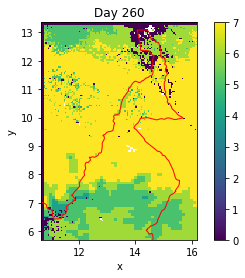

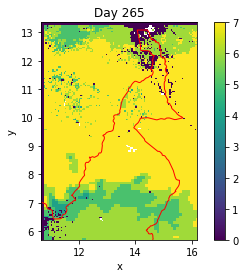

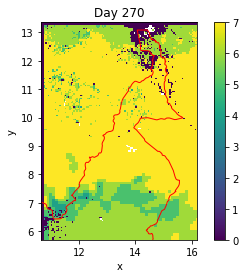

In [47]:
variable = "numPhase"
time_resolution = 5
vmax = data[variable].max().values

# load country boundaries for cameroon from the web
gdf = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")
gdf = gdf[gdf["ADMIN"] == "Cameroon"]

for i in range(int(round(duration/time_resolution,0))):
    # data[variable][time_resolution*i,:,:].plot(vmin=0, vmax=vmax)
    xr.where(np.isnan(data["ru"]),np.nan,data[variable][time_resolution*i,:,:]).plot(vmin=0, vmax=vmax)
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.title("Day %s" % (i*time_resolution))
    plt.show()

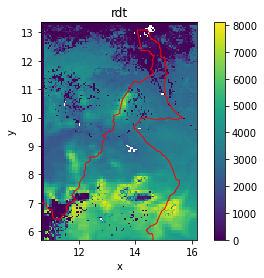

In [48]:
variable = "rdt"
gdf = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")
gdf = gdf[gdf["ADMIN"] == "Cameroon"]

xr.where(np.isnan(data["ru"]),np.nan,data[variable][-1,:,:]).plot()
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("%s" % (variable))
plt.show()

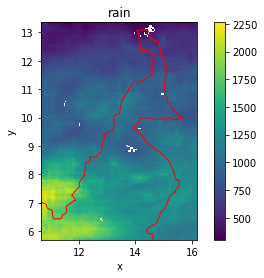

In [60]:
variable = "rain"
xr.where(np.isnan(data["ru"]),np.nan,data[variable].sum(dim="time")).plot()
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("%s" % (variable))
plt.show()

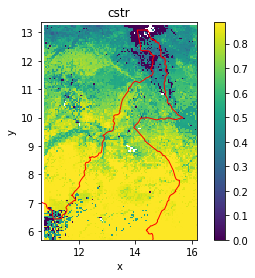

In [59]:
variable = "cstr"
xr.where(np.isnan(data["ru"]),np.nan,data[variable].mean(dim="time")).plot()
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("%s" % (variable))
plt.show()

In [56]:
import hvplot.xarray
data[variable][-1,:,:].hvplot(height=600, width=600)

:Image   [x,y]   (rdtPot)